Here, we summarise the results of the tests on real EMCCD images. Unlike the simulated image tests -- which used both over- and undersampled synthetic images -- all real images are in the oversampled regime.

In [1]:
# imports
import numpy as np
from astropy.stats import mad_std
from scipy.stats import norm
from astropy.stats import mad_std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#out_pd = np.vstack((MFBs_pd, MFVs_pd, Ps_normalised_pd, np.array(norm_phot_resids_pd).flatten(),
#                         image_SNRs_pd, image_FWHMs_pd, stamp_ids_pd, ll_pds)).T

#PyTorch_data = np.genfromtxt('PyTorchDIA_OGLE_BLG101_betterLnL.txt')
#pyDANDIA_data = np.genfromtxt('pyDANDIA_OGLE_BLG101_betterLnL.txt')
#flux_fraction = np.genfromtxt('Flux_fraction.txt')

#pd_data = np.genfromtxt('pyDANDIA_OGLE_BLG101_December2020_TestRun.txt')
#pt_data = np.genfromtxt('PyTorchDIA_OGLE_BLG101_December_2020_TestRun.txt')

pd_data = np.genfromtxt('pyDANDIA_OGLE_BLG101_January2021_TestRun.txt')
pt_data = np.genfromtxt('PyTorchDIA_OGLE_BLG101_January2021_TestRun.txt')
print(pd_data.shape, pt_data.shape)
#pd_data, pt_data
pt_data[:, - 1]

(25434, 9) (25434, 9)


array([  0.,   0.,   0., ..., 249., 249., 249.])

In [3]:
# if NaNs are present, remove these
# NaNs from PyTorchDIA
pd_data = pd_data[~np.isnan(pt_data).any(axis=1)]
pt_data = pt_data[~np.isnan(pt_data).any(axis=1)]
print(pd_data.shape, pt_data.shape)
# NaNs from pyDANDIA / B08
#pd_data = pd_data[~np.isnan(pd_data).any(axis=1)]
#pd_data = pt_data[~np.isnan(pd_data).any(axis=1)]
#print(pd_data.shape, pt_data.shape)
pd_data, pt_data

(25420, 9) (25420, 9)


(array([[1.99322980e-02, 2.36324130e+00, 1.07826506e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.03310823e-03, 1.66661198e+00, 9.98051145e-01, ...,
         1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.10322584e-02, 2.11805378e+00, 1.00318514e+00, ...,
         2.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [8.97667536e-03, 2.02979027e+00, 9.99766564e-01, ...,
         1.03000000e+02, 0.00000000e+00, 2.49000000e+02],
        [4.42155970e-03, 1.95426639e+00, 9.98540749e-01, ...,
         1.04000000e+02, 0.00000000e+00, 2.49000000e+02],
        [1.43849505e-03, 2.10899828e+00, 1.05671282e+00, ...,
         1.05000000e+02, 0.00000000e+00, 2.49000000e+02]]),
 array([[6.53449544e-02, 2.42376740e+00, 1.07694621e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.44574314e-03, 1.68956862e+00, 9.98774850e-01, ...,
         1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.91541874e-02, 

First, let's have a look at the log-likelihoods for both approaches. As the B08/pyDANDIA approach uses sigma-clipping to remove outlying pixels -- in contrast to PyTorchDIA, which uses all the data by optimising a robust loss function -- in order to compare the two likelihoods, we need to ensure we limit the comparison to cases in which no data has been rejected from the B08 solution.

In [4]:
# identify subset of stamps in which no data was rejected
pd_lls, pt_lls = pd_data[:,7], pt_data[:,7]
ndr = np.where(pd_lls != 0)[0] # no-data-rejected
pd_lls, pt_lls = pd_lls[ndr], pt_lls[ndr]
pd_lls.shape, pt_lls.shape

((2108,), (2108,))

In [5]:
# compute likelihood ratio
# L(A) / L(B) = exp(l(A) - l(B))
lr = np.exp(pd_lls - pt_lls)
# fraction where PyTorchDIA better
pt_win = len(lr[lr < 1])
print('Model under Huber loss preffered %.3f percent of the time.' % (100 * (pt_win/len(lr))))
#plt.hist(lr, bins=50)
#plt.xlim(-0.1, 1e3)
lr

Model under Huber loss preffered 9.393 percent of the time.


array([1.44613007e-12, 3.92620439e+19, 1.99647442e+64, ...,
       6.80650377e+95, 4.13090539e-05, 2.78010345e+60])

OK, let's move on to the other metrics. As with the simulated images results notebook, we'll use pandas in combination with seaborn to plot the metrics separated into SNR categories, and gain some insight into the distribution of each of the metrics and the correlations between them.

In [6]:
## apply a signal-to-noise ratio cut
pd_data = pd_data[pd_data[:,4] < 1000]
pt_data = pt_data[pt_data[:,4] < 1000]
print(pd_data.shape, pt_data.shape)

(23651, 9) (23651, 9)


In [7]:
def numpy_to_DataFrame(array):
    
    # out = np.vstack((MFBs, MFVs, Ps_normalised, np.array(norm_phot_resids).flatten(),
    #                 image_SNRs, image_FWHMs, stamp_ids, ll)).T
    
    df = pd.DataFrame(array, columns=['MFB', 'MFV', '$P$',
                                      '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$',
                                      '$\mathrm{SNR}_{I}$',
                                      '$\mathrm{FWHM}_{I}$',
                                      'Stamp ID', 'log-likelihood', 'Image id'])


    
    # categories
    # SNR: 3 categories
    # 8 < $\mathrm{SNR}_{I}$ < 40, 40 < $\mathrm{SNR}_{I}$ < 200, 200 < $\mathrm{SNR}_{I}$ < 1000
    cat1, cat2, cat3 = '8 < $\mathrm{SNR}_{I}$ < 40', '40 < $\mathrm{SNR}_{I}$ < 200', '200 < $\mathrm{SNR}_{I}$ < 1280'

    df['SNR regime'] = 0
    df['SNR regime'][(8. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 40.)] = cat1
    df['SNR regime'][(40. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 200.)] = cat2
    df['SNR regime'][(200. < df['$\mathrm{SNR}_{I}$'])] = cat3
    
    df = df[df['SNR regime']!= 0]
    
    # remove variable source (stamp 1)
    #df = df[df['Stamp ID'] != 1.0]
    
    # set to categorical type
    df['SNR regime'] = df['SNR regime'].astype('category')
    
    # sampling: 2 categories
    # under-/over-sampled reference or kernel
    # a critically sampled gaussian PSF has sigma = 1 pixel (or equivalently, FWHM = 2.35 pixels)
    cat4 = '$\phi_R > 1, \phi_K > 1$'
    cat5 = '$\phi_R > 1, \phi_K < 1$'
    
    ref_fwhm = 5.625057500773691
    df['$\phi_k$'] = np.sqrt(df['$\mathrm{FWHM}_{I}$']**2 - ref_fwhm**2) / 2.355
    df['Sampling regime'] = 0
    df['Sampling regime'][(df['$\phi_k$'] > 1)] = cat4
    df['Sampling regime'][(df['$\phi_k$'] < 1)] = cat5
    df = df[df['Sampling regime']!= 0]
    

    
    ## drop unecessary columns
    df = pd.DataFrame.drop(df, columns=['$\mathrm{FWHM}_{I}$', '$\mathrm{SNR}_{I}$',
                                        'Stamp ID', 'log-likelihood', 'Image id'])
    
    # rearrange columns in correct order
    cols = df.columns.to_list()
    cols = [cols[2], cols[0], cols[1], cols[3], cols[4], cols[6]]     
    df = df[cols]
    
    ## metrics by SNR regime
    snr_cats = [cat1, cat2, cat3]
    
    sampling_cats = [cat4, cat5]
    
    output_metrics = np.zeros((3*2, 5))
    output_16 = np.zeros((3*2, 5)) # 16 percentile
    output_84 = np.zeros((3*2, 5)) # 84 percentile
    
    i = 0
        
    for snr in snr_cats:
        for sampling in sampling_cats:
            
            # SNR regime
            print('\nSNR regime:', snr)
            print('Sampling regime:', sampling)
                        
            # fit quality metrics
            Ps = df['$P$'][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]
            MFBs = df['MFB'][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]
            MFVs = df['MFV'][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]
            
            print('Number of entries:', len(Ps))
            
            if len(Ps) > 0:
            
                # photometric accuracy metrics
                colname = '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'
                nr = df[colname][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]
                nr = df[colname][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]

                # remove bad outliers
                sigma = mad_std(nr)
                nr = nr[nr < np.nanmedian(nr) + 5*sigma]
                nr = nr[nr > np.nanmedian(nr) - 5*sigma]
                #print('\n\nNot Removing Outliers!!\n\n')
                #print('\n\nRemoving 5-sigma (MAD) Outliers!!\n\n')


                MPB = 1./len(nr) * np.nansum(nr)
                MPV = 1./(len(nr) - 1) * np.nansum((nr - MPB)**2)
                MedPB = np.nanmedian(nr)
                MedPV = (mad_std(nr))**2  

                print('|   P  |  MFB   |   MFV |   MPB |  MPV  |')
                results = np.array([np.median(Ps), np.median(MFBs), np.median(MFVs), MPB, MPV])

                np.set_printoptions(precision=4, suppress=True)
                print(results)

                #output_metrics = np.append(output_metrics, [np.nanmedian(Ps), np.nanmedian(MSEs),np.nanmedian(MFBs),
                #                                            np.nanmedian(MFVs), MPB, MPV])
                output_metrics[i] = [np.nanmedian(Ps), np.nanmedian(MFBs), np.nanmedian(MFVs), MPB, MPV]

                # upper and lower 34th percentiles i.e. 16 and 84 percentiles
                def errbr(array):
                    med = np.median(array)
                    return (np.percentile(array, [16, 84]) - med)
                output_16[i] = [errbr(Ps)[0], errbr(MFBs)[0], errbr(MFVs)[0], 0, 0]
                output_84[i] = [errbr(Ps)[1], errbr(MFBs)[1], errbr(MFVs)[1], 0, 0]

            i += 1

        
    return df, output_metrics, output_16, output_84

print('pyDANDIA')
pyDANDIA_df, metrics_pd, pd_16, pd_84 = numpy_to_DataFrame(pd_data)
print('\nPyTorch')
PyTorch_df, metrics_pt, pt_16, pt_84 = numpy_to_DataFrame(pt_data)

pyDANDIA

SNR regime: 8 < $\mathrm{SNR}_{I}$ < 40
Sampling regime: $\phi_R > 1, \phi_K > 1$
Number of entries: 43
|   P  |  MFB   |   MFV |   MPB |  MPV  |
[ 1.0444 -0.0003  1.1563  3.5666  5.3843]

SNR regime: 8 < $\mathrm{SNR}_{I}$ < 40
Sampling regime: $\phi_R > 1, \phi_K < 1$
Number of entries: 0

SNR regime: 40 < $\mathrm{SNR}_{I}$ < 200
Sampling regime: $\phi_R > 1, \phi_K > 1$
Number of entries: 8892
|   P  |  MFB   |   MFV |   MPB |  MPV  |
[ 0.9955  0.0004  1.2157 -1.8628 14.7109]

SNR regime: 40 < $\mathrm{SNR}_{I}$ < 200
Sampling regime: $\phi_R > 1, \phi_K < 1$
Number of entries: 70
|   P  |  MFB   |   MFV |   MPB |  MPV  |
[ 0.9981 -0.0007  1.2136  2.4751 12.8595]

SNR regime: 200 < $\mathrm{SNR}_{I}$ < 1280
Sampling regime: $\phi_R > 1, \phi_K > 1$
Number of entries: 13895


/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


|   P  |  MFB   |   MFV |   MPB |  MPV  |
[ 1.0015  0.0015  1.3634 -2.3396 18.3351]

SNR regime: 200 < $\mathrm{SNR}_{I}$ < 1280
Sampling regime: $\phi_R > 1, \phi_K < 1$
Number of entries: 751
|   P  |  MFB   |   MFV |   MPB |  MPV  |
[ 1.0005 -0.0018  1.3915  3.5633 17.2339]

PyTorch

SNR regime: 8 < $\mathrm{SNR}_{I}$ < 40
Sampling regime: $\phi_R > 1, \phi_K > 1$
Number of entries: 43
|   P  |  MFB   |   MFV |   MPB |  MPV  |
[1.0462 0.0102 1.1786 2.3138 2.478 ]

SNR regime: 8 < $\mathrm{SNR}_{I}$ < 40
Sampling regime: $\phi_R > 1, \phi_K < 1$
Number of entries: 0

SNR regime: 40 < $\mathrm{SNR}_{I}$ < 200
Sampling regime: $\phi_R > 1, \phi_K > 1$
Number of entries: 8892
|   P  |  MFB   |   MFV |   MPB |  MPV  |
[ 0.9955  0.0164  1.2241 -1.875  14.4893]

SNR regime: 40 < $\mathrm{SNR}_{I}$ < 200
Sampling regime: $\phi_R > 1, \phi_K < 1$
Number of entries: 70
|   P  |  MFB   |   MFV |   MPB |  MPV  |
[ 0.9971  0.017   1.2163  2.8176 12.9219]

SNR regime: 200 < $\mathrm{SNR}_{I}$ < 1

In [8]:
metrics_pd, metrics_pt

(array([[ 1.0444, -0.0003,  1.1563,  3.5666,  5.3843],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.9955,  0.0004,  1.2157, -1.8628, 14.7109],
        [ 0.9981, -0.0007,  1.2136,  2.4751, 12.8595],
        [ 1.0015,  0.0015,  1.3634, -2.3396, 18.3351],
        [ 1.0005, -0.0018,  1.3915,  3.5633, 17.2339]]),
 array([[ 1.0462,  0.0102,  1.1786,  2.3138,  2.478 ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.9955,  0.0164,  1.2241, -1.875 , 14.4893],
        [ 0.9971,  0.017 ,  1.2163,  2.8176, 12.9219],
        [ 1.0019,  0.0178,  1.3775, -2.4108, 18.9764],
        [ 1.0011,  0.0224,  1.3961,  3.6804, 17.5598]]))

[[ 1.      1.0444 -0.0003  1.1563  3.5666  5.3843]
 [ 1.      0.      0.      0.      0.      0.    ]
 [ 2.      0.9955  0.0004  1.2157 -1.8628 14.7109]
 [ 2.      0.9981 -0.0007  1.2136  2.4751 12.8595]
 [ 3.      1.0015  0.0015  1.3634 -2.3396 18.3351]
 [ 3.      1.0005 -0.0018  1.3915  3.5633 17.2339]]
[[ 1.      1.0462  0.0102  1.1786  2.3138  2.478 ]
 [ 1.      0.      0.      0.      0.      0.    ]
 [ 2.      0.9955  0.0164  1.2241 -1.875  14.4893]
 [ 2.      0.9971  0.017   1.2163  2.8176 12.9219]
 [ 3.      1.0019  0.0178  1.3775 -2.4108 18.9764]
 [ 3.      1.0011  0.0224  1.3961  3.6804 17.5598]]
Metric & SNR regime & $\phi_R > 1, \phi_K > 1$ & $\phi_R > 1, \phi_K < 1$ \\
\hline
$P$ (B08) & 1 & $1.0444_{-0.0246}^{+0.0339}$ & $0.0000_{0.0000}^{+0.0000}$ \\
$P$ (PyTorchDIA) & 1 & $1.0462_{-0.0239}^{+0.0531}$ & $0.0000_{0.0000}^{+0.0000}$ \\
$P$ (B08) & 2 & $0.9955_{-0.0182}^{+0.0382}$ & $0.9981_{-0.0072}^{+0.0069}$ \\
$P$ (PyTorchDIA) & 2 & $0.9955_{-0.0180}^{+0.0369}$ & $0.997

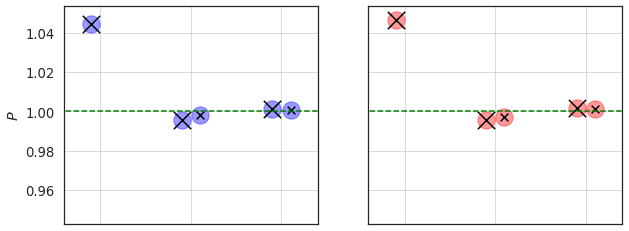

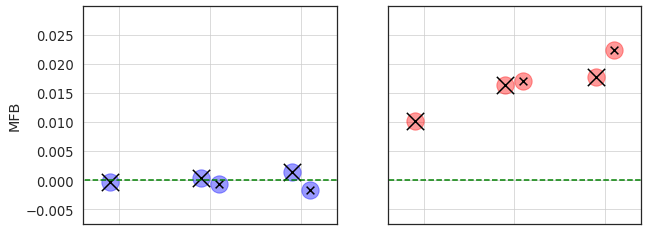

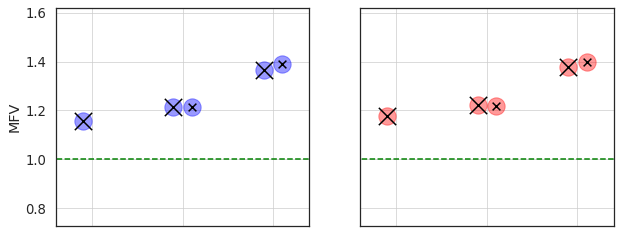

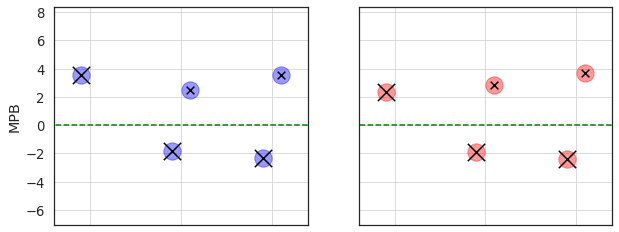

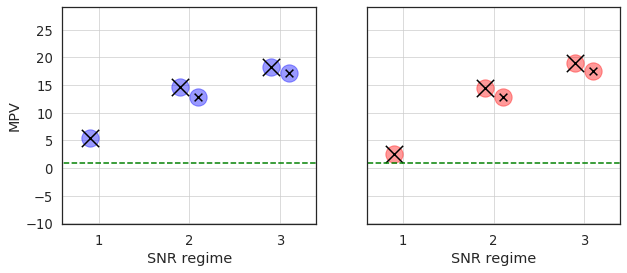

In [12]:
snr_regime = np.array([1, 2, 3]) # 1 -> 3 == increasing SNR regime
snr_regimes = np.repeat(snr_regime, 2).reshape((3*2,1))
test_metrics_pd = np.hstack((snr_regimes, metrics_pd))
test_metrics_pt = np.hstack((snr_regimes, metrics_pt))

# try this out with photometric scale factors
x_pd = test_metrics_pd[:,0]
x_pt = test_metrics_pt[:,0]

print(test_metrics_pd)
print(test_metrics_pt)

# fit quality and photometric accuracy metrics
categories = ['$P$','MFB', 'MFV', 'MPB', 'MPV']

# target value
target = [1, 0, 1, 0, 1]

# 'o' == reference frame, 'x' == kernel
markers = ['o','x']
# oversampled / undersampled markersizes
os, us = 300, 60 # ax.scatter
#os, us = 6, 6

# fontsize
fs = 16

plt.rcParams.update({'font.size': fs})


print("Metric & SNR regime & $\phi_R > 1, \phi_K > 1$ & $\phi_R > 1, \phi_K < 1$ \\\\")
print("\hline")

for i,cat in enumerate(categories):
    
    y_pd = test_metrics_pd[:,i+1]
    y_pt = test_metrics_pt[:,i+1]
    
    yerr_pd_16 = pd_16[:,i]
    yerr_pt_16 = pt_16[:,i]
    yerr_pd_84 = pd_84[:,i]
    yerr_pt_84 = pt_84[:,i]
    
    ymin, ymax = np.min(y_pt), np.max(y_pt)
    
    if i == 0 or i == 2:
        ymin = 0.95
    
    pad = 1.5*mad_std(y_pt)
    #pad = 5*mad_std(y_pt)

    j = 0
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    #fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

    
    if i == len(categories) - 1:
        plt.setp(ax, xticks=[1, 2, 3], xlabel='SNR regime', xlim=(0.6, 3.4), ylim=(ymin-pad, ymax+pad))
        
    else:
        plt.setp(ax, xticks=[1,2,3], xlim=(0.6, 3.4), ylim=(ymin-pad, ymax+pad))
        
    plt.setp(ax[0], ylabel=cat)

    if target[i] is not 'NaN':
        ax[0].hlines(target[i], 0, 4, color='green', linestyle='--')
        ax[1].hlines(target[i], 0, 4, color='green', linestyle='--')


    ax[0].grid(alpha=0.7, which='major')
    ax[1].grid(alpha=0.7, which='major')
    
    if i == len(categories) - 1:
        ax[0].set_xticklabels([1,2,3])
        ax[1].set_xticklabels([1,2,3])
        ax[1].set_yticklabels(())

    else:
        #ax[0].set_yticklabels(())
        ax[1].set_yticklabels(())
        ax[0].set_xticklabels(())
        ax[1].set_xticklabels(())
        
    offsets = np.linspace(-0.1, 0.1, 2)
    
    ### print output for latex table ###
    y_pd1, y_pd2, y_pd3 = y_pd[0:2], y_pd[2:4], y_pd[4:6]
    y_pd1err16, y_pd2err16, y_pd3err16 = yerr_pd_16[0:2], yerr_pd_16[2:4], yerr_pd_16[4:6]
    y_pd1err84, y_pd2err84, y_pd3err84 = yerr_pd_84[0:2], yerr_pd_84[2:4], yerr_pd_84[4:6]
    y_pt1, y_pt2, y_pt3 = y_pt[0:2], y_pt[2:4], y_pt[4:6]
    y_pt1err16, y_pt2err16, y_pt3err16 = yerr_pt_16[0:2], yerr_pt_16[2:4], yerr_pt_16[4:6]
    y_pt1err84, y_pt2err84, y_pt3err84 = yerr_pt_84[0:2], yerr_pt_84[2:4], yerr_pt_84[4:6]

    def latex_fmt4p(c, snrreg, y, yerr16, yerr84):
        print("%s & %d & $%.4f_{%.4f}^{+%.4f}$ & $%.4f_{%.4f}^{+%.4f}$ \\\\" %
              (c, snrreg, y[0], yerr16[0], yerr84[0], y[1], yerr16[1], yerr84[1]))

    def latex_fmt3p(c, snrreg, y, yerr16, yerr84):
        print("%s & %d & $%.3f_{%.3f}^{+%.3f}$ & $%.3f_{%.3f}^{+%.3f}$ \\\\" %
              (c, snrreg, y[0], yerr16[0], yerr84[0], y[1], yerr16[1], yerr84[1]))

    def latex_fmt2p(c, snrreg, y, yerr16, yerr84):
        print("%s & %d & $%.2f_{%.2f}^{+%.2f}$ & $%.2f_{%.2f}^{+%.2f}$ \\\\" %
              (c, snrreg, y[0], yerr16[0], yerr84[0], y[1], yerr16[1], yerr84[1]))

    def table_fmt(cat, snrreg, y_pd, y_pderr16, y_pderr84, y_pt, y_pterr16, y_pterr84):
        if cat == "$P$" or cat == 'MFB' or cat == 'MFV':  
            latex_fmt4p(cat + " (B08)", snrreg, y_pd, y_pderr16, y_pderr84)
            latex_fmt4p(cat + " (PyTorchDIA)", snrreg, y_pt, y_pterr16, y_pterr84)

        elif cat == 'MPB' or cat == 'MPV':
            latex_fmt3p(cat + " (B08)", snrreg, y_pd, y_pderr16, y_pderr84)
            latex_fmt3p(cat + " (PyTorchDIA)", snrreg, y_pt, y_pterr16, y_pterr84)

        else:
            latex_fmt2p(cat + " (B08)", snrreg, y_pd, y_pderr16, y_pderr84)
            latex_fmt2p(cat + " (PyTorchDIA)", snrreg, y_pt, y_pterr16, y_pterr84)

    table_fmt(cat, 1, y_pd1, y_pd1err16, y_pd1err84, y_pt1, y_pt1err16, y_pt1err84)
    table_fmt(cat, 2, y_pd2, y_pd2err16, y_pd2err84, y_pt2, y_pt2err16, y_pt2err84)
    table_fmt(cat, 3, y_pd3, y_pd3err16, y_pd3err84, y_pt3, y_pt3err16, y_pt3err84)

    print("\hline")
    


            
    for xpd, xpt, ypd, ypt, err16pd, err16pt, err84pd, err84pt, in zip(x_pd, x_pt, y_pd, y_pt,
                                                                       yerr_pd_16, yerr_pt_16,
                                                                       yerr_pd_84, yerr_pt_84):
                
        if j == 0:
            rs, ks = os, os
        elif j == 1:
            rs, ks = os, us
            
        # offset to space points
        xpd += offsets[j]
        xpt += offsets[j]

        j += 1

        if j == 2:
            j = 0
            

        if [ypd] != [ypt] != 0:
            
            ax[0].scatter([xpd],[ypd], marker='o', s=rs, c='blue', alpha=0.4)
            ax[0].scatter([xpd],[ypd], marker='x', s=ks, c='black')
            ax[1].scatter([xpt],[ypt], marker='o', s=rs, c='red', alpha=0.4)
            ax[1].scatter([xpt],[ypt], marker='x', s=ks, c='black')
        
        #ax[2].scatter([xpd],[ypd - ypt], marker='o', s=rs, c='black')
        #ax[2].scatter([xpd],[ypd - ypt], marker='x', s=ks, c='black')
        #ax[0].errorbar(xpd, ypd, yerr=[[err16pd], [err84pd]], marker='o',
        #               markersize=rs, c='blue', alpha=0.4)
        #ax[0].errorbar(xpd, ypd, marker='x', markersize=ks, c='black')
        #ax[1].errorbar(xpt, ypt, yerr=[[err16pt], [err84pt]], marker='o',
        #               markersize=rs, c='red', alpha=0.4)
        #ax[1].errorbar(xpt, ypt, marker='x', markersize=ks, c='black')    
        
        
        fname = cat + '_real_results_.png'
        
        if i == len(categories) - 1:
            #plt.savefig(fname, bbox_inches='tight')
            #x0, y0, x1, y1 = 0, 0, 1, 1
            #bbox = np.array([[x0, y0], [x1, y1]]).reshape(2, 2)
            plt.savefig(fname, bbox_inches='tight')
            #plt.savefig(fname)

        else:
            plt.savefig(fname)
        

KeyError: 'SNR category'

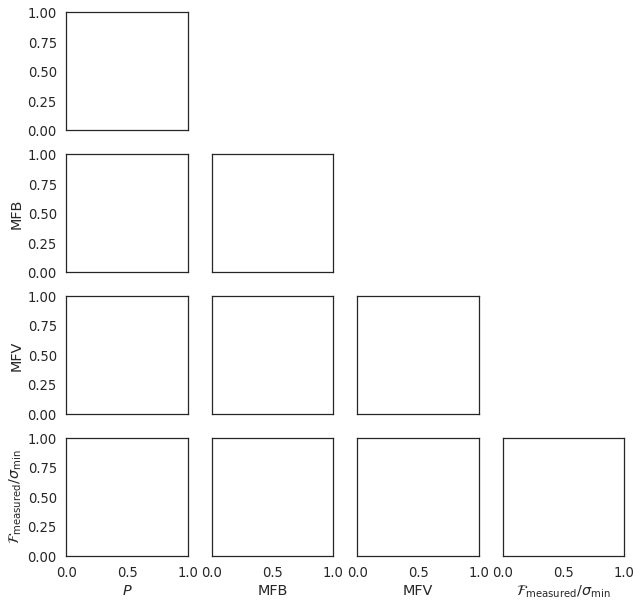

In [10]:
sns.set(context='notebook', font_scale = 1.2, style='white')
sns.pairplot(PyTorch_df, hue='SNR category', corner=True)
#plt.savefig('Corner_plot_PyTorch_real_data_.png')
#plt.show()

#sns.set(context='notebook', font_scale = 1.2, style='white')
#sns.pairplot(pyDANDIA_df, hue='SNR category', corner=True)
#plt.show()

In [ ]:
# for clarity when plotting, exclude bad outliers
def clip(df):
    
    labels = ['$P$', 'MFB', 'MFV', '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$']
    
    for label in labels:
        column = df[label]
        std = mad_std(column)
        sigma = 5
        column[column > np.median(column) + sigma*std] = 0
        column[column < np.median(column) - sigma*std] = 0
        
        #if label == '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$':
        #    print('MPB:', np.mean(column))
        #    print('MPV:', (np.std(column))**2)
          
    clipped_df = df[df != 0]
    
    return clipped_df
        
PyTorch_df_clipped = clip(PyTorch_df)

In [ ]:
### cut outliers from plots for clarity
sns.set(context='notebook', font_scale = 1.2, style='white')
pp = sns.pairplot(PyTorch_df_clipped, hue='SNR category', corner=True)
#pp.axes[1,0].set_ylim(-0.2,0.2)
#pp.axes[3,1].set_xlim(-0.2,0.2)
#pp.axes[2,0].set_ylim(0.8, 3.5)
#pp.axes[3,2].set_xlim(0.8, 3.5)
#pp.axes[3,0].set_xlim(0.8, 1.35)
#pp.axes[3,1].tick_params(labelsize=10)
#pp.axes[4,2].tick_params(labelsize=12)
plt.savefig('Corner_plot_PyTorch_real_data_.png', bbox_inches='tight')

In [10]:
#### difference column for paper ####
diff = np.abs(pyDANDIA_metrics - PyTorch_metrics)
for d in diff:
    print(d)

0.0017989689663944208
0.010478443902440654
0.022349857997522093
1.2528224502538525
2.9063830767818764
3.4467163456897154e-05
0.01608491862736339
0.008440735357575502
0.01091661471075489
0.17130380029905368
0.0004549392786239448
0.017525875129528495
0.013383539151170076
0.07406383770422997
0.7410376384776249


In [1]:
28785 / 155

185.70967741935485

In [ ]:
for snr_cat in snr_cats:
        print('\n')
        print(snr_cat)
        print('$P$:', np.median(df['$P$'][df['SNR snr_category'] == snr_cat]))
        N_set = len(df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR snr_category'] == snr_cat])
        print('MFB:', np.median(df['MFB'][df['SNR snr_category'] == snr_cat]))
        print('MFV:', np.median(df['MFV'][df['SNR snr_category'] == snr_cat]))
        nr = df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR snr_category'] == snr_cat]
        # remove bad outliers
        sigma = mad_std(nr)
        nr = nr[nr < np.nanmedian(nr) + 5*sigma]
        nr = nr[nr > np.nanmedian(nr) - 5*sigma]
        MPB = np.mean(nr)
        MPV = np.std(nr, ddof=1)**2
        print('N_set:', N_set)
        print('MPB:', MPB)
        print('MPV:', MPV)
        print('MedPB:', np.median(df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR snr_category'] == snr_cat]))
        sigmad = mad_std(df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR snr_category'] == snr_cat])
        print('MedPV:', sigmad**2)
        
        output_metrics = np.append(output_metrics, [np.median(df['$P$'][df['SNR snr_category'] == snr_cat]),
                                                   np.median(df['MFB'][df['SNR snr_category'] == snr_cat]),
                                                   np.median(df['MFV'][df['SNR snr_category'] == snr_cat]),
                                                   MPB, MPV])
        

In [15]:
(25420  - (106 * 249)) / (106 * 249) * 100

-3.6902326286277183

In [15]:
(751 + 70) / (8892 + 13895)

0.03602931496028437

In [16]:
9 / 241

0.03734439834024896